In [7]:
# To allow changes in .py files to be reflected in Notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Drift Using MOA

Randomly select streams to use for drift stream generation. Check summary statistics to determine value for n_drift during drift generation. 

In [8]:
from util.stream import Stream, DriftStream
from util.drift_generator import DriftGenerator
import numpy as np
import pandas as pd

In [25]:
source_dir = '/Users/tammyz/Desktop/AnomalyDriftDetection/data/benchmark/ECG'
drift_dir = '/Users/tammyz/Desktop/AnomalyDriftDetection/data/synthetic'
moa_path = '/Users/tammyz/Desktop/moa-release-2023.04.0/lib'
# source_dir = '/home/zengt5/AnomalyDriftDetection/data/benchmark/IOPS'
# drift_dir = '/home/zengt5/AnomalyDriftDetection/data/synthetic'
# moa_path = '/home/zengt5/moa-release-2023.04.0/lib'
num_streams = 6
g = DriftGenerator(source_dir, drift_dir, moa_path, num_streams)

In [26]:
df = g.get_source_summary()
df

,filename,len,num_anomalies,total_anom_cover,avg_anomaly_len,percent_anomalies
1,MBA_ECG14046_data_1.arff,229900,447,36478,81.606264,0.158669
26,MBA_ECG14046_data_32.arff,229900,132,10288,77.939394,0.044750
30,MBA_ECG14046_data_36.arff,229900,153,11788,77.045752,0.051274
32,MBA_ECG14046_data_38.arff,229900,360,27841,77.336111,0.121100
50,MBA_ECG820_data.arff,230400,191,14386,75.319372,0.062439


In [27]:
df.describe()

,len,num_anomalies,total_anom_cover,avg_anomaly_len,percent_anomalies
count,5.000000,5.000000,5.00000,5.000000,5.000000
mean,230000.000000,256.600000,20156.20000,77.849378,0.087647
std,223.606798,139.198779,11469.09605,2.314762,0.049904
min,229900.000000,132.000000,10288.00000,75.319372,0.044750
25%,229900.000000,153.000000,11788.00000,77.045752,0.051274
50%,229900.000000,191.000000,14386.00000,77.336111,0.062439
75%,229900.000000,360.000000,27841.00000,77.939394,0.121100
max,230400.000000,447.000000,36478.00000,81.606264,0.158669


In [28]:
mean_num_anom = 250
percent = np.arange(0.1,0.8,0.1)
percent_anom = mean_num_anom * percent
pd.DataFrame([percent_anom], columns=percent)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7
0,25.0,50.0,75.0,100.0,125.0,150.0,175.0


The following parameters can be assigned in the next cell to guide characteristics of the generated drift stream:

- `length`: int, total length of new stream
- `p_drift`: float, target percent of data points classified as drift
- `n_drift`: int, target number of drift sequences
- `p_before`: float, target percent of drift coming before anomaly
- `sub_dir`: string, name of subdirectory to export drift stream
- `dataset`: string, descriptor (name) or source dataset for identification
- `mode`: int, indicator for drift assembly method, options {0,1}, default 0
    - Mode 0: variable drift widths and positions
    - Mode 1: uniform drift widths and positions (helpful for high p_drift)
- Returns `output_path, drift_label, positions, streams, seq_before`


Note: If you encounter trouble with generating large percentage drift, you can use `mode=1`.

In [29]:
length = 229900
n_drift = 28
p_drift = 0.35
p_drift_before = 0.5
sub_dir = 'n_drift/n_a10'
dataset = 'ECG'

In [30]:
drift_stream = g.run_generate_grad_stream_moa(
    length, 
    p_drift, 
    n_drift,
    p_drift_before, 
    sub_dir,
    dataset,
    mode=0 # 0 for variable drift widths and positions, 1 for uniform
)

Generating splits...
	Getting partitions...
	Getting order of drifts coming before anomaly...
	Getting drift center positions...
	Getting stream file cuts...
Done!
Getting stream file cuts...	Done!
Creating intermediate files...	Done!
Recursively generating MOA command...	Done!
Drift filename:  ECG_grad_p34_n27_b50
Running terminal command...	


{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 1.26s (CPU time)



Stream written to ARFF file /Users/tammyz/Desktop/AnomalyDriftDetection/data/synthetic/n_a10/ECG_grad_p34_n27_b50.arff
Done!
Generating drift labels...	Done!


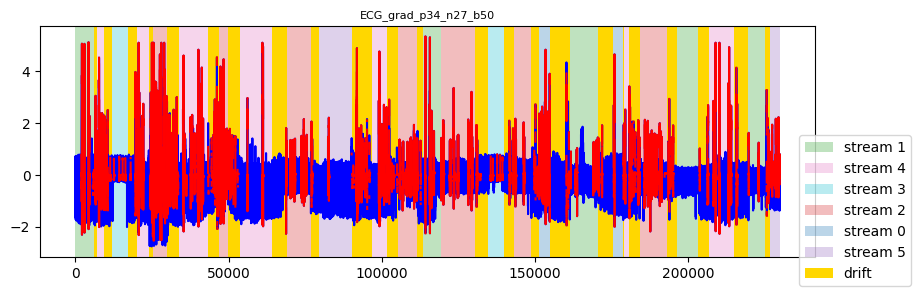

In [31]:
drift_stream.plot_drift()

## Update an Existing Data Stream

#### Read data and set up object to generate new data stream

In [32]:
# Read existing data file
from util.stream import DriftStream

# source_dir = "data/benchmark/IOPS" # directory for source streams
source_dir = '/Users/tammyz/Desktop/AnomalyDriftDetection/data/benchmark/ECG'
output_path = '/Users/tammyz/Desktop/AnomalyDriftDetection/data/synthetic/n_drift/n_a10/ECG_grad_p34_n27_b50.arff'
d1 = DriftStream(output_path, source_dir)

In [33]:
# Create object to generate new data stream
g2 = DriftGenerator(source_dir, drift_dir, moa_path, selected_streams=d1.source_streams)
positions = d1.positions # this variable returns positions from above with [0] appended to the front
streams = d1.streams
seq_before = d1.seq_before
w_drift = d1.w_drift

#### The following values can be modified individually to make changes to the data stream

In [34]:
# View index values
k = 4
w = 3
index = [i for i in range(k-w,k+w,1)]
pd.DataFrame({'positions': positions[k-w:k+w], 'streams (after)': streams[k-w:k+w], 'seq_before': seq_before[k-w-1:k+w-1], 'w_drift': w_drift[k-w-1:k+w-1]}, index=index)

,positions,streams (after),seq_before,w_drift
1,6509,4,True,1117
2,10649,3,True,2453
3,18763,4,False,2975
4,24599,2,True,1333
5,31772,4,False,3972
6,45079,2,False,3625


In [ ]:
streams[60]

In [ ]:
positions[2] -= 1200

In [46]:
w_drift[53] = 250

In [31]:
seq_before[84] = True

In [ ]:
# Remove a drift by selecting the index to remove (r_i)
r_i = 3
positions = positions[:r_i] + positions[r_i+1:]
streams = streams[:r_i] + streams[r_i+1:]
w_drift[r_i] = w_drift[r_i-1] + w_drift[r_i]
w_drift = w_drift[:r_i-1] + w_drift[r_i:]
seq_before = seq_before[:r_i-1] + seq_before[r_i:]

In [390]:
index = [i for i in range(k-w,k+w,1)]
pd.DataFrame({'positions': positions[k-w:k+w], 'streams (after)': streams[k-w:k+w], 'w_drift': w_drift[k-w-1:k+w-1]}, index=index)

,positions,streams (after),w_drift
30,98398,5,344
31,108581,4,5097
32,110528,0,24
33,116615,4,1675


#### Generate new data stream based on updated drift characteristics

In [51]:
output_path, drift_label =  g2.assemble_drift_stream(
    positions[1:-1],
    streams,
    w_drift,
    seq_before,
    sub_dir='n_drift/n_a50',
    length=d1.length,
    dataset='IOPS'
)

Getting stream file cuts...	Done!
Creating intermediate files...	

Done!
Recursively generating MOA command...	Done!
Drift filename:  IOPS_grad_p35_n21_b50
Running terminal command...	


{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 0.51s (CPU time)



Stream written to ARFF file /home/zengt5/AnomalyDriftDetection/data/synthetic/n_drift/n_a50/IOPS_grad_p35_n21_b50.arff
Done!
Generating drift labels...	Done!
